In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import numpy as np
import random
from datetime import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.behaviors.event_manager import EventManager
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.utils import to_nd
from tyssue.io import hdf5
from tyssue.behaviors.sheet.basic_events import exchange as type1_transition
from tyssue.behaviors.sheet.basic_events import check_tri_faces
from tyssue.behaviors.sheet.delamination_events import constriction

from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import VitellineElasticity
from invagination.delamination import (define_mesoderm,
                                       check_enter_in_process)

from invagination.plots import mesoderm_position


import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/Surface_tension')


In [2]:
import datetime

today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [3]:
#%pdb

In [4]:
from invagination.ellipsoid import VitellineElasticity, RadialTension

model = model_factory([effectors.FaceAreaElasticity, 
                       effectors.CellVolumeElasticity,
                       effectors.SurfaceTension,
                       effectors.LineTension,
                       VitellineElasticity,
                       RadialTension], effectors.FaceAreaElasticity)

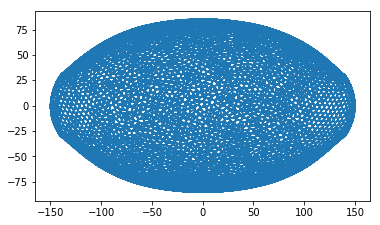

In [5]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet_init.hf5',
                           data_names=['vert', 'edge', 'face', 'cell'])


with open('../data/json/ellipsoid.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('ellipse', dsets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.settings['vitelline_space'] = 0.2
sheet.vert_df['radial_tension'] = 0.
sheet.cell_df['prefered_vol'] = 4539601.384437251
sheet.cell_df['vol_elasticity'] = 3.e-6
sheet.face_df['surface_tension'] = 10.
sheet.face_df['contractility'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('zx'))

In [6]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                          'options': {'ftol': 1e-8,
                                      'gtol': 1e-8}}}

## Define cells in the mesoderm

number of apoptotic cells: 859


(<matplotlib.figure.Figure at 0x7ff695489860>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff699f9b9e8>,
       dtype=object))

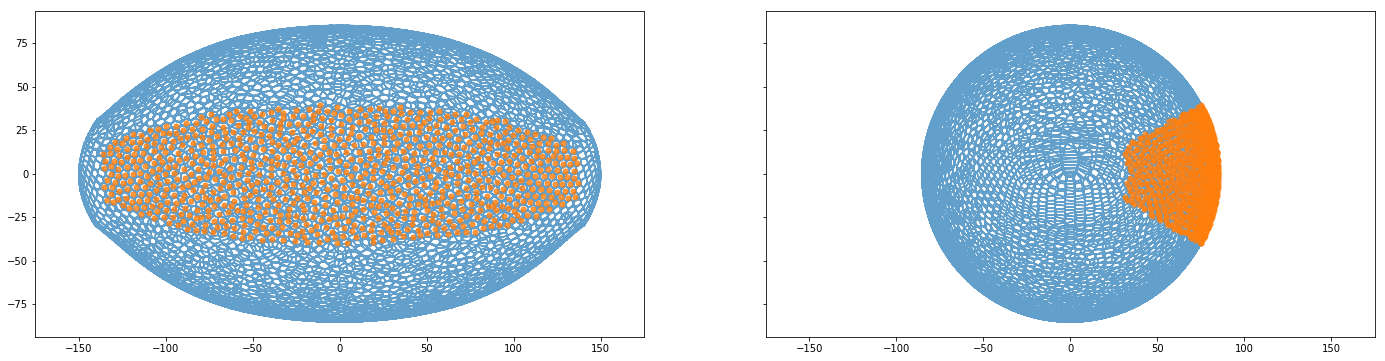

In [7]:
# Define rectangular mesoderm
#define_cell_in_mesoderm(sheet, 0.3, 0.7 ,0.05, 0.95)

# Define ovoid mesoderm
define_mesoderm(sheet, 145, 40)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
delaminating_cells = sheet.face_df[sheet.face_df['is_mesoderm']].index



print('number of apoptotic cells: {}'.format(delaminating_cells.size))
mesoderm_position(sheet, delaminating_cells)

In [8]:
from tyssue.solvers.sheet_vertex_solver import Solver
from mesher.cgal_mesher import (import_sheet_into_Mesh,
                                does_self_intersect,
                                self_intersections)

from mesher.cgal_mesher import (Mesh)

class CollisionSolver(Solver):
    @classmethod
    def opt_energy(cls, pos, pos_idx, sheet, geom, model):
        # Keep old position safe 
        vert_df_old = sheet.vert_df
        cls.set_pos(pos, pos_idx, sheet)
        geom.update_all(sheet)
        
        # Collide test 
        # and correct collision if needed
        vertices, faces = sheet.triangular_mesh(sheet.coords, False)
        vertices = np.array(vertices, order='C')
        faces = np.array(faces, order='C')
        mesh = import_sheet_into_Mesh(faces, vertices)
        
        if does_self_intersect(mesh):
            tuple_intersected_edges = self_intersections(mesh)
            
            # flatten tuple into liste
            list_intersected_edges = [y for x in tuple_intersected_edges for y in x]
            srce = sheet.edge_df.loc[(list_intersected_edges), 'srce'].values
            trgt = sheet.edge_df.loc[(list_intersected_edges), 'trgt'].values
            vert_to_modify = np.unique(np.append(srce, trgt))
            
            sheet.vert_df.loc[vert_to_modify, ['x', 'y', 'z']] = vert_df_old.loc[vert_to_modify,['x', 'y', 'z']].values        
        
        geom.update_all(sheet)
        return model.compute_energy(sheet, full_output=False)


## Processus functions

In [9]:
import logging
logger = logging.Logger('event_log')


@do_undo
def run_sim(sheet, mesoderm, geom, model, dirname,
           max_contractility_rate, profile_width, k):
    
    solver = CollisionSolver
    
    # logger initiation
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
        
    #Initiate manager
    manager = EventManager('face')
    sheet.face_df['enter_in_process'] = 0  
    
    t=0
    stop = 200
    
    # Add all cells in constriction process 
    for f in mesoderm:
        x = sheet.face_df.loc[f, 'x']
        c_rate = 1+(max_contractility_rate-1) * ((1+np.exp(-k*profile_width))/
                                          (1+np.exp(k*(abs(x)-profile_width))))


        delam_kwargs = sheet.settings["delamination"].copy()
        delam_kwargs.update(
            {
                'face_id':f,
                'contract_rate': c_rate,
                'current_traction': 0,
                'max_traction':30
            }
        )
        manager.append(constriction, **delam_kwargs)
        
    while manager.current and t < stop:
    #while t<stop:
        print("TEMPS : ", t)
        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        sheet.face_df['contractility'] = 0
        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)
        if not res['success']:
            warnings.warn(str(res['message']))

        
        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)

        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3]+'hf5'
        hdf5.save_datasets(hdfname, sheet)      
        
    
        
        # Add cells with initially 3 neighbourghs to be eliminated
        check_tri_faces(sheet, manager)
        # Add T1 transition for face with at least one edge shorter than critical length
        #[manager.append(type1_transition, f, kwargs=sheet.settings['T1']) for f in sheet.edge_df[
        #    sheet.edge_df['length'] < sheet.settings['T1']['critical_length']]['face'].unique()]
    
    
        manager.update()
        t+=1
        
        
    logger.removeHandler(hdlr)
    return sheet


In [ ]:
def delamination_process(sheet, max_contractility_rate, critical_area, 
                         radial_tension, nb_iteraction_max, 
                         profile_width, k):
    # Directory definition 
    dirname = '{}_contractility_{}_critical_area_{}_radialtension'.format(
                max_contractility_rate, critical_area, radial_tension)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    settings = {'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration':0,
            'nb_iteration_max':nb_iteraction_max,
            'contract_neighbors':True,
            'critical_area_neighbors':20,
            'contract_span':5,
            'basal_contract_rate':1.001,
            'geom': geom,
            'contraction_column': 'surface_tension'}

    solver = CollisionSolver
    
    # Add some information to the sheet
    sheet2 = sheet.copy(deep_copy=True)
    
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['delamination'] = settings
    
    settings2 = {'critical_length':0.3}
    sheet2.settings['T1'] = settings2
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    res = solver.find_energy_min(sheet2, geom, model, **solver_kw)
   
    sheet2 = run_sim(sheet2, delaminating_cells, geom, model, dirname,
                     max_contractility_rate, profile_width, k)


    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

## Sequential execution 

In [ ]:
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

profile_width = 25
k = 0.19
nb_iter = 30
critical_area = 5

radial_tension = [30]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]

for rad in radial_tension:
    for contracts in contractility_rate:
        print ('rad : ' + str(rad)+ '\tcontract : ' + str(contracts))
        delamination_process(sheet, contracts, critical_area,
                             rad, nb_iter,
                            profile_width, k)
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2018-11-16 12:04:13.161652
rad : 30	contract : 1.08
starting /home/admin-suz/Documents/Simulations/Surface_tension/2018-11-16/1.08_contractility_5_critical_area_30_radialtension


/home/admin-suz/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


TEMPS :  0
TEMPS :  1
TEMPS :  2
TEMPS :  3
TEMPS :  4
TEMPS :  5
TEMPS :  6
TEMPS :  7
TEMPS :  8
TEMPS :  9
TEMPS :  10
TEMPS :  11
TEMPS :  12
TEMPS :  13
TEMPS :  14


## Parallel execution

In [ ]:
"""
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()

profile_width = 25
k = 0.19
nb_iter = 30
critical_area = 5

radial_tension = [0, 10, 20, 30, 40]
contractility_percent = [4, 8, 16, 32]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(delamination_process)(
    sheet, c, critical_area, r, nb_iter, profile_width, k) 
                             for c, r in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)
"""